In [1]:
# default_exp test

# Import

In [2]:
# export
import torch
import numpy as np
from scipy.stats import multivariate_normal

import camera_calib_python
from camera_calib_python.cb_geom import *
from camera_calib_python.control_refine import *
from camera_calib_python.utils import *
from camera_calib_python.modules import *

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

from camera_calib_python.control_refine import checker_opencv
from camera_calib_python.fiducial_detect import DotVisionCheckerDLDetector
from camera_calib_python.image import File16bitImg

# Test

### Checker refiner

In [4]:
h_cb = 50.8
w_cb = 50.8
h_f = 42.672
w_f = 42.672
num_c_h = 16
num_c_w = 16
spacing_c = 2.032

In [5]:
cb_geom = CbGeom(h_cb, w_cb,
                 CpCSRGrid(num_c_h, num_c_w, spacing_c),
                 FmCFPGrid(h_f, w_f))

In [6]:
ps_f_w = cb_geom.ps_f
ps_c_w = cb_geom.ps_c
bs_c_w = cb_geom.bs_c

Detect fiducial markers

In [7]:
file_model = Path('/home/justin/justinblaber/camera_calib_python/models/dot_vision_checker.pth')
file_img = Path('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png')

In [8]:
img = File16bitImg(file_img)

In [9]:
ps_f_detector = DotVisionCheckerDLDetector(file_model)

In [10]:
ps_f_p = ps_f_detector(img.array_gs)

Estimate homography

In [11]:
H_init = homography(ps_f_w, ps_f_p)
H_init

array([[ 1.08005286e+00, -1.84333327e+01,  5.70068894e+02],
       [ 1.96498664e+01, -1.30037589e-01,  9.13011954e+02],
       [ 1.23962123e-03,  6.10272613e-04,  1.00000000e+00]])

In [12]:
ps_c_p = pmm(H_init, ps_c_w, aug=True)

In [13]:
bs_c_p = np.array([pmm(H_init, b_c_w, aug=True) for b_c_w in bs_c_w], np.object)

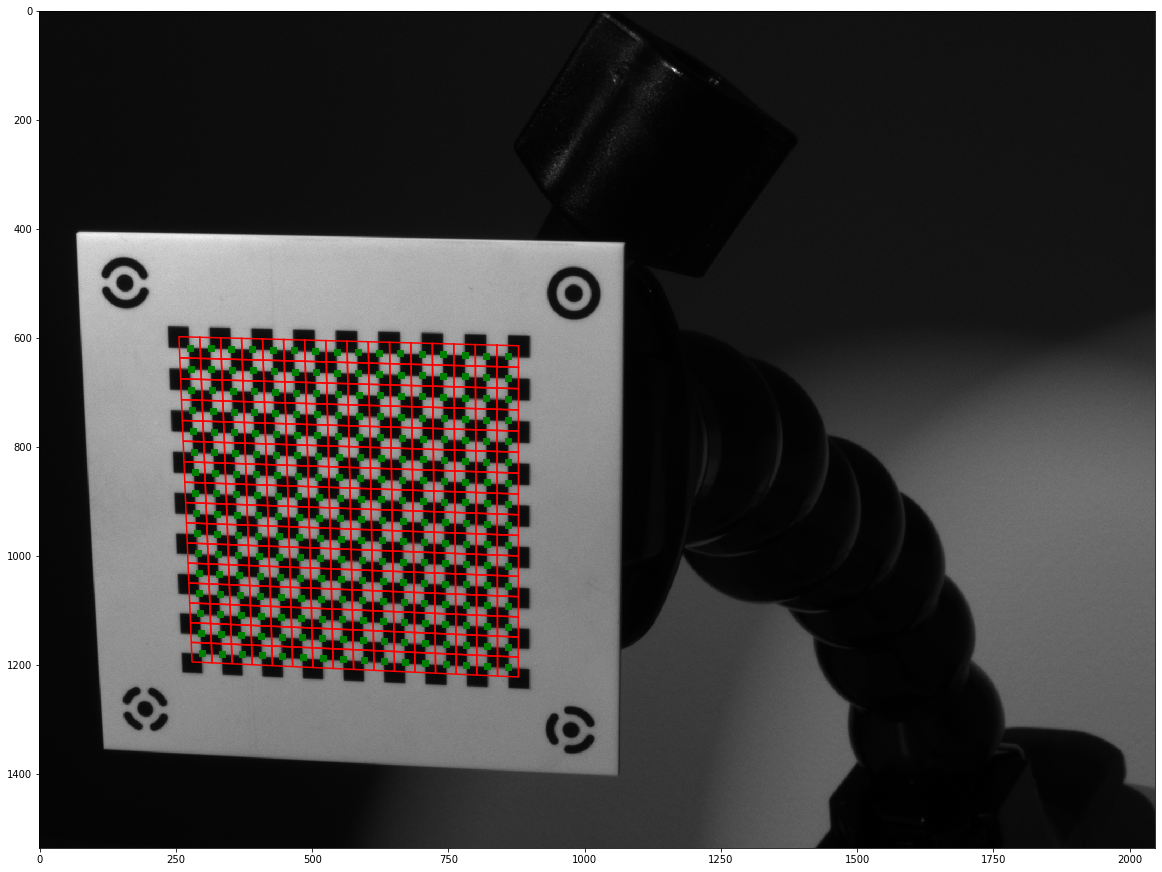

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(img.array_gs, cmap='gray')
plt.plot(ps_c_p[:,0], ps_c_p[:,1], 'gs')
for b_c_p in bs_c_p:
    plt.plot(np.r_[b_c_p[:,0],b_c_p[0,0]], np.r_[b_c_p[:,1],b_c_p[0,1]],'r')

In [15]:
refiner = OpenCVCheckerRefiner(hw_min=3, hw_max=10, cutoff_it=5, cutoff_norm=1e-2)

In [16]:
ps_c_p = refiner(img.array_gs, ps_c_p, bs_c_p)

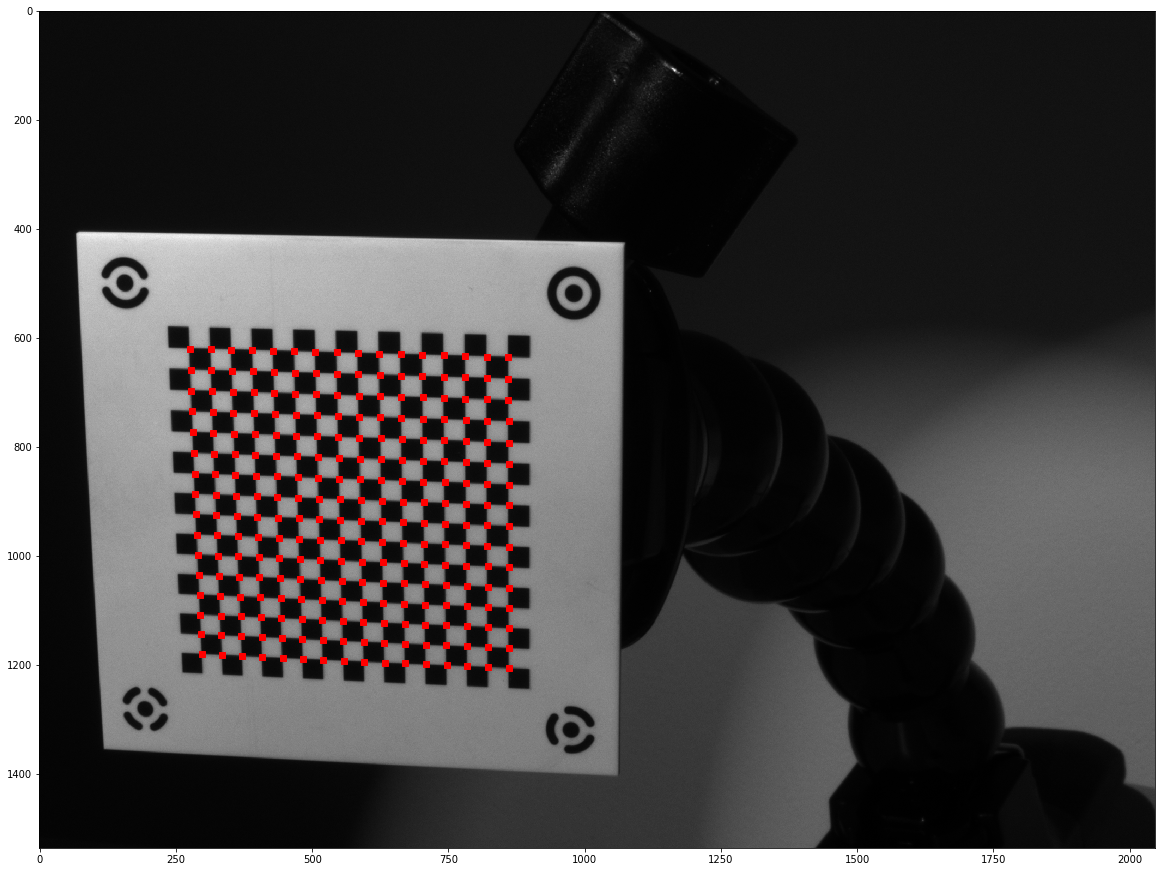

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(img.array_gs, cmap='gray')
plt.plot(ps_c_p[:,0], ps_c_p[:,1],'rs')

### Ellipse refiner

In [18]:
file_img = Path('data/dot_vision_circle/SERIAL_19061245_DATETIME_2020-05-17-20:48:11-005188_CAM_1_FRAMEID_0_COUNTER_1.png')

In [19]:
img = File16bitImg(file_img)

In [20]:
ps_f_p = np.array([
    [510,1228],
    [1440,1231],
    [512,308],
    [1434,296]
])

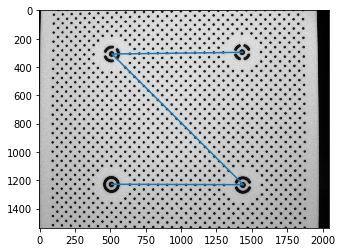

In [21]:
plt.imshow(img.array_gs, cmap='gray')
plt.plot(ps_f_p[:,0], ps_f_p[:,1])

In [22]:
h_cb = 1500
w_cb = 1500
h_f = 700
w_f = 700
num_c_h = 55
num_c_w = 55
spacing_c = 25
fo = True
idx_c_exclude = np.array([
   0,    1,   28,   55,  281,  282,  308,  309,  310,  335,  336,
 337,  338,  363,  364,  365,  390,  391,  392,  393,  418,  419,
 420,  446,  447,   26,   27,   54,   82,  295,  296,  322,  323,
 324,  349,  350,  351,  352,  377,  378,  379,  404,  405,  406,
 407,  432,  433,  434,  460,  461, 1430, 1458, 1485, 1486, 1051,
1052, 1078, 1079, 1080, 1105, 1106, 1107, 1108, 1133, 1134, 1135,
1160, 1161, 1162, 1163, 1188, 1189, 1190, 1216, 1217, 1457, 1484,
1511, 1512, 1065, 1066, 1092, 1093, 1094, 1119, 1120, 1121, 1122,
1147, 1148, 1149, 1174, 1175, 1176, 1177, 1202, 1203, 1204, 1230,
1231
])

In [23]:
cb_geom = CbGeom(h_cb, w_cb,
                 CpCSDGrid(num_c_h, num_c_w, spacing_c, fo),
                 FmCFPGrid(h_f, w_f),
                 idx_c_exclude)

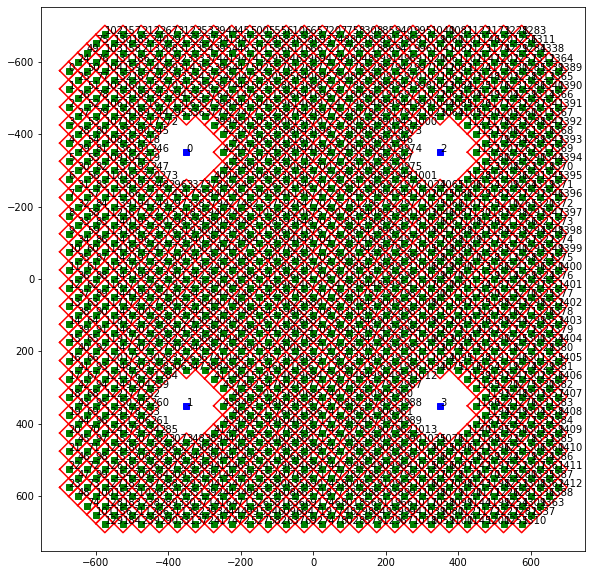

In [24]:
cb_geom.plt()

In [25]:
ps_c_w = cb_geom.ps_c
bs_c_w = cb_geom.bs_c
ps_f_w = cb_geom.ps_f

In [26]:
H_init = homography(ps_f_w, ps_f_p)
H_init

array([[ 9.16143695e-03,  1.30027158e+00,  9.70242098e+02],
       [-1.31550066e+00, -2.42119000e-02,  7.63773122e+02],
       [ 1.22918412e-05, -2.31632180e-05,  1.00000000e+00]])

In [27]:
ps_c_p = pmm(H_init, ps_c_w, aug=True)

In [28]:
bs_c_p = np.array([pmm(H_init, b_c_w, aug=True) for b_c_w in bs_c_w], np.object)

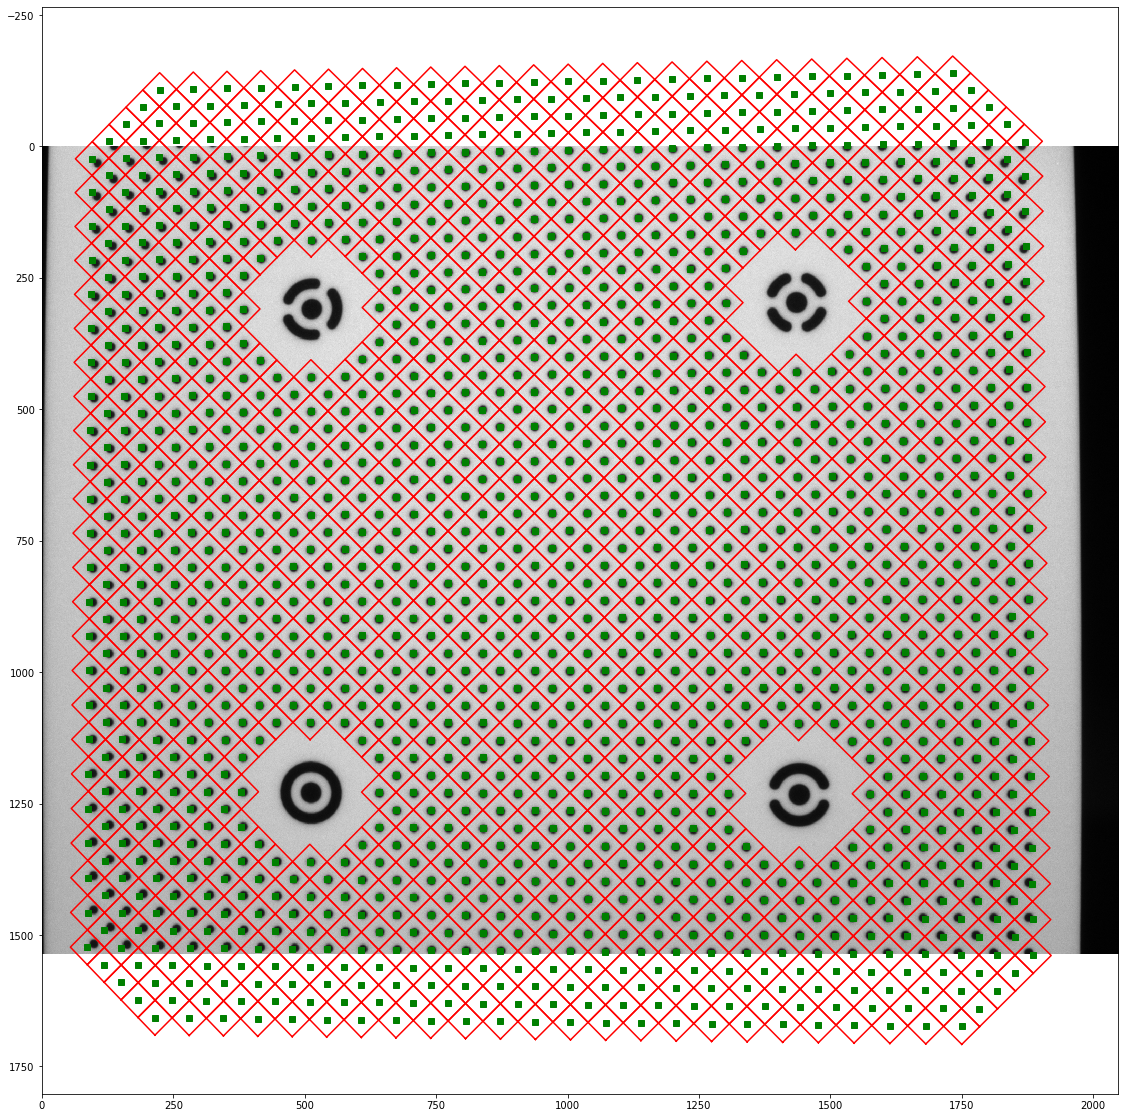

In [29]:
plt.figure(figsize=(20,20))
plt.imshow(img.array_gs, cmap='gray')
plt.plot(ps_c_p[:,0], ps_c_p[:,1], 'gs')
for b_c_p in bs_c_p:
    plt.plot(np.r_[b_c_p[:,0],b_c_p[0,0]], np.r_[b_c_p[:,1],b_c_p[0,1]],'r')

In [30]:
refiner = DualConicEllipseRefiner(cutoff_it=5, cutoff_norm=1e-2)

In [31]:
ps_c_p = refiner(img.array_gs, ps_c_p, bs_c_p)

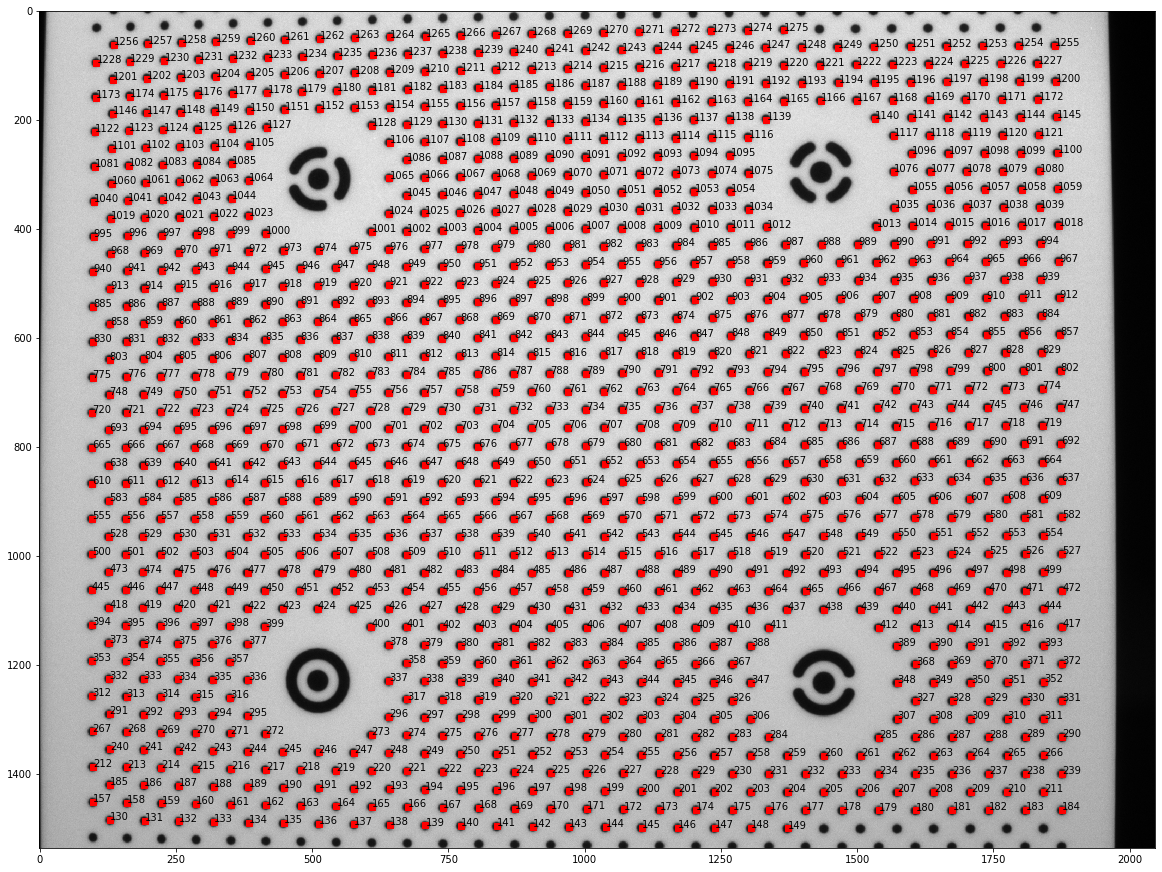

In [32]:
plt.figure(figsize=(20,20))
plt.imshow(img.array_gs, cmap='gray')
plt.plot(ps_c_p[:,0], ps_c_p[:,1],'rs')
for idx, p_c_p in enumerate(ps_c_p): 
    if np.all(np.isfinite(p_c_p)): 
        plt.text(p_c_p[0], p_c_p[1], str(idx))

### Initial guess

These are inputs

In [6]:
h_cb = 50.8
w_cb = 50.8
h_f = 42.672
w_f = 42.672
num_c_h = 16
num_c_w = 16
spacing_c = 2.032
cb_geom = CbGeom(h_cb, w_cb,
                 CpCSRGrid(num_c_h, num_c_w, spacing_c),
                 FmCFPGrid(h_f, w_f))

In [7]:
file_model = Path('/home/justin/justinblaber/camera_calib_python/models/dot_vision_checker.pth')
ps_f_detector = DotVisionCheckerDLDetector(file_model)

In [8]:
refiner = OpenCVCheckerRefiner(hw_min=3, hw_max=10, cutoff_it=5, cutoff_norm=1e-2)

In [9]:
imgs = [File16bitImg(file_img) for file_img in Path('data/dot_vision_checker').glob('*CAM_2*.png')]

In [10]:
imgs

#### Pipeline

Get points

In [11]:
ps_f_w = cb_geom.ps_f
ps_c_w = cb_geom.ps_c
bs_c_w = cb_geom.bs_c

Get initial homographies

In [12]:
Hs = []
for img in imgs:
    ps_f_p = ps_f_detector(img.array_gs)
    Hs.append(homography(ps_f_w, ps_f_p))

Get refined points

In [13]:
pss_c_p = []
for img, H in zip(imgs, Hs):
    ps_c_p = pmm(H, ps_c_w, aug=True)
    bs_c_p = np.array([pmm(H, b_c_w, aug=True) for b_c_w in bs_c_w], np.object)
    pss_c_p.append(refiner(img.array_gs, ps_c_p, bs_c_p))

Update homographies with optimized calibration board pixel points

In [14]:
for idx, ps_c_p in enumerate(pss_c_p):
    Hs[idx] = homography(ps_c_w, ps_c_p)

Get Initial guess for camera matrix; distortion is assumed to be zero

In [15]:
def init_intrin(Hs, sz):
    yo, xo = (np.array(sz)-1)/2
    po_inv = np.array([[1, 0, -xo],
                       [0, 1, -yo],
                       [0, 0,   1]])
    A, b = [np.empty(0) for _ in range(2)]
    for H in Hs:
        H_bar = po_inv@H
        v1, v2 = H_bar[:,0], H_bar[:,1]
        v3, v4 = v1+v2, v1-v2
        v1, v2, v3, v4 = unitize(np.stack([v1, v2, v3, v4]))
        A = np.r_[A, np.array([v1[0]*v2[0]+v1[1]*v2[1], v3[0]*v4[0]+v3[1]*v4[1]])]
        b = np.r_[b, np.array([-v1[2]*v2[2], -v3[2]*v4[2]])]
    alpha = np.sqrt(np.dot(b,A)/np.dot(b,b))
    return np.array([[alpha,     0, xo],
                     [    0, alpha, yo],
                     [    0,     0,  1]])

In [16]:
A = init_intrin(Hs, imgs[0].size)

Get initial guess for extrinsics

In [17]:
def init_extrin(H, A):
    H_bar = np.linalg.inv(A)@H
    lambdas = np.linalg.norm(H_bar, axis=0)
    r1, r2 = [H_bar[:,idx]/lambdas[idx] for idx in range(2)]
    r3 = np.cross(r1, r2)
    R = approx_R(np.c_[r1,r2,r3])
    t = H_bar[:,2]/np.mean(lambdas[0:2])
    return R, t

In [18]:
Rs, ts = [], []
for H in Hs:
    R, t = init_extrin(H, A)
    Rs.append(R)
    ts.append(t)

Perform refinement of parameters

In [19]:
ps_c_w = torch.Tensor(np.c_[ps_c_w, np.zeros(len(ps_c_w))])
pss_c_p = [torch.Tensor(ps_c_p) for ps_c_p in pss_c_p]

In [20]:
cam = CamSF(torch.Tensor(A))
distort = Heikkila97Distortion(0,0,0,0)

In [21]:
rigids = [Rigid(torch.Tensor(R), torch.Tensor(t)) for R,t in zip(Rs,ts)]

In [22]:
ms = [torch.nn.Sequential(rigids[idx], 
                          Normalize(), 
                          distort, 
                          cam)
      for idx, (R,t) in enumerate(zip(Rs, ts))]
ms

[Sequential(
   (0): Rigid(
     (ms): ModuleList(
       (0): EulerRotation(ex:-0.3004 ey:-0.2289 ez:1.674)
       (1): Translation(tx:-13.92 ty:5.591 tz:155.1)
     )
   )
   (1): Normalize()
   (2): Heikkila97Distortion(k1:0.0 k2:0.0 p1:0.0 p2:0.0)
   (3): CamSF(alpha:3.58e+03 x_o:1.024e+03 y_o:767.5)
 ), Sequential(
   (0): Rigid(
     (ms): ModuleList(
       (0): EulerRotation(ex:-0.4245 ey:-0.1343 ez:2.301)
       (1): Translation(tx:1.029 ty:2.94 tz:158.7)
     )
   )
   (1): Normalize()
   (2): Heikkila97Distortion(k1:0.0 k2:0.0 p1:0.0 p2:0.0)
   (3): CamSF(alpha:3.58e+03 x_o:1.024e+03 y_o:767.5)
 )]

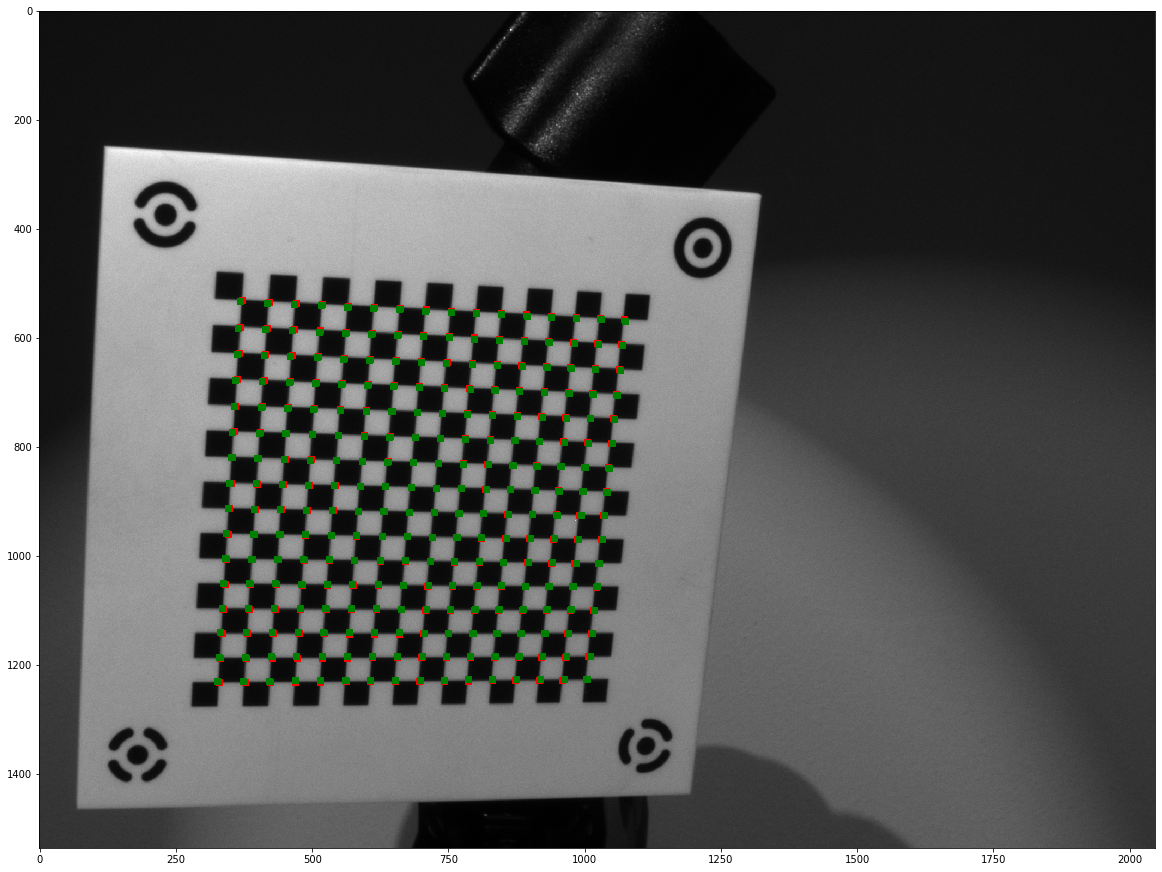

In [23]:
idx=0
plt.figure(figsize=(20,20))
plt.imshow(imgs[idx].array_gs, cmap='gray')
plt.plot(pss_c_p[idx][:,0], pss_c_p[idx][:,1], 'rs')
plt.plot(torch2np(ms[idx](ps_c_w))[:,0], torch2np(ms[idx](ps_c_w))[:,1], 'gs')

In [24]:
loss = torch.nn.functional.mse_loss

In [25]:
    def _get_loss():
        return torch.sum(torch.stack([loss(ps_c_p, m_w2p(ps_c_w)) for m_w2p, ps_c_p in zip(ms_w2p, pss_c_p)]))
    
    def _get_params():
        return sum([list(m.parameters()) for m in [cam, distort]+rigids], [])

In [29]:
torch.cat([p.view(-1) for p in _get_params()])

tensor([ 3.5802e+03,  1.0235e+03,  7.6750e+02,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -3.0042e-01, -2.2893e-01,  1.6739e+00,
        -1.3921e+01,  5.5915e+00,  1.5510e+02, -4.2451e-01, -1.3431e-01,
         2.3009e+00,  1.0294e+00,  2.9403e+00,  1.5874e+02],
       grad_fn=<CatBackward>)

In [23]:
params = torch.cat(sum([[p.view(-1) for p in list(m.parameters())] for m in [cam, distort]+rigids], []))
params

tensor([ 3.5802e+03,  1.0235e+03,  7.6750e+02,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -3.0042e-01, -2.2893e-01,  1.6739e+00,
        -1.3921e+01,  5.5915e+00,  1.5510e+02, -4.2451e-01, -1.3431e-01,
         2.3009e+00,  1.0294e+00,  2.9403e+00,  1.5874e+02],
       grad_fn=<CatBackward>)

In [24]:
cutoff_norm = 1e-3

In [25]:
optim = torch.optim.LBFGS(sum([list(m.parameters()) for m in [cam, distort]+rigids], []))

In [26]:
num_epochs = 10
params_prev = torch.cat(sum([[p.view(-1) for p in list(m.parameters())] for m in [cam, distort]+rigids], []))
for epoch in range(num_epochs):
    def closure():
        optim.zero_grad()
        l = torch.sum(torch.stack([loss(ps_c_p, m(ps_c_w)) for m, ps_c_p in zip(ms, pss_c_p)]))
        l.backward()
        return l
    optim.step(closure)
    params = torch.cat(sum([[p.view(-1) for p in list(m.parameters())] for m in [cam, distort]+rigids], []))
    print(torch.norm(params-params_prev))
    if torch.norm(params-params_prev) < cutoff_norm: break
    print(torch.sum(torch.stack([loss(ps_c_p, m(ps_c_w)) for m, ps_c_p in zip(ms, pss_c_p)])).item())
    params_prev = params

tensor(0.0442, grad_fn=<NormBackward0>)
0.2865089774131775
tensor(0.1275, grad_fn=<NormBackward0>)
0.17537668347358704
tensor(0.8448, grad_fn=<NormBackward0>)
0.014895595610141754
tensor(0.1903, grad_fn=<NormBackward0>)
0.0146804703399539
tensor(0.1135, grad_fn=<NormBackward0>)
0.014537369832396507
tensor(0., grad_fn=<NormBackward0>)


In [27]:
optim._params

[Parameter containing:
 tensor(3580.2686, requires_grad=True), Parameter containing:
 tensor(1023.5090, requires_grad=True), Parameter containing:
 tensor(767.5140, requires_grad=True), Parameter containing:
 tensor(-0.1670, requires_grad=True), Parameter containing:
 tensor(0.2206, requires_grad=True), Parameter containing:
 tensor(-0.0009, requires_grad=True), Parameter containing:
 tensor(0.0002, requires_grad=True), Parameter containing:
 tensor(-0.3318, requires_grad=True), Parameter containing:
 tensor(-0.2098, requires_grad=True), Parameter containing:
 tensor(1.6745, requires_grad=True), Parameter containing:
 tensor([-13.8752,   5.5733, 154.1881], requires_grad=True), Parameter containing:
 tensor(-0.4189, requires_grad=True), Parameter containing:
 tensor(-0.1296, requires_grad=True), Parameter containing:
 tensor(2.2996, requires_grad=True), Parameter containing:
 tensor([  1.0300,   2.9434, 158.7437], requires_grad=True)]

In [28]:
l = torch.sum(torch.stack([loss(ps_c_p, m(ps_c_w)) for m, ps_c_p in zip(ms, pss_c_p)]))

In [29]:
from torchviz import make_dot

In [30]:
idx=0; make_dot(l).view()

'Digraph.gv.pdf'

In [31]:
torch.cat(sum([[p.view(-1) for p in list(m.parameters())] for m in [cam, distort]+rigids], []))

tensor([ 3.5803e+03,  1.0235e+03,  7.6751e+02, -1.6695e-01,  2.2063e-01,
        -8.5658e-04,  1.9321e-04, -3.3185e-01, -2.0979e-01,  1.6745e+00,
        -1.3875e+01,  5.5733e+00,  1.5419e+02, -4.1894e-01, -1.2961e-01,
         2.2996e+00,  1.0300e+00,  2.9434e+00,  1.5874e+02],
       grad_fn=<CatBackward>)

In [32]:
ms

[Sequential(
   (0): Rigid(
     (ms): ModuleList(
       (0): EulerRotation(ex:-0.3318 ey:-0.2098 ez:1.674)
       (1): Translation(tx:-13.88 ty:5.573 tz:154.2)
     )
   )
   (1): Normalize()
   (2): Heikkila97Distortion(k1:-0.167 k2:0.2206 p1:-0.0008566 p2:0.0001932)
   (3): CamSF(alpha:3.58e+03 x_o:1.024e+03 y_o:767.5)
 ), Sequential(
   (0): Rigid(
     (ms): ModuleList(
       (0): EulerRotation(ex:-0.4189 ey:-0.1296 ez:2.3)
       (1): Translation(tx:1.03 ty:2.943 tz:158.7)
     )
   )
   (1): Normalize()
   (2): Heikkila97Distortion(k1:-0.167 k2:0.2206 p1:-0.0008566 p2:0.0001932)
   (3): CamSF(alpha:3.58e+03 x_o:1.024e+03 y_o:767.5)
 )]

In [33]:
cam

CamSF(alpha:3.58e+03 x_o:1.024e+03 y_o:767.5)

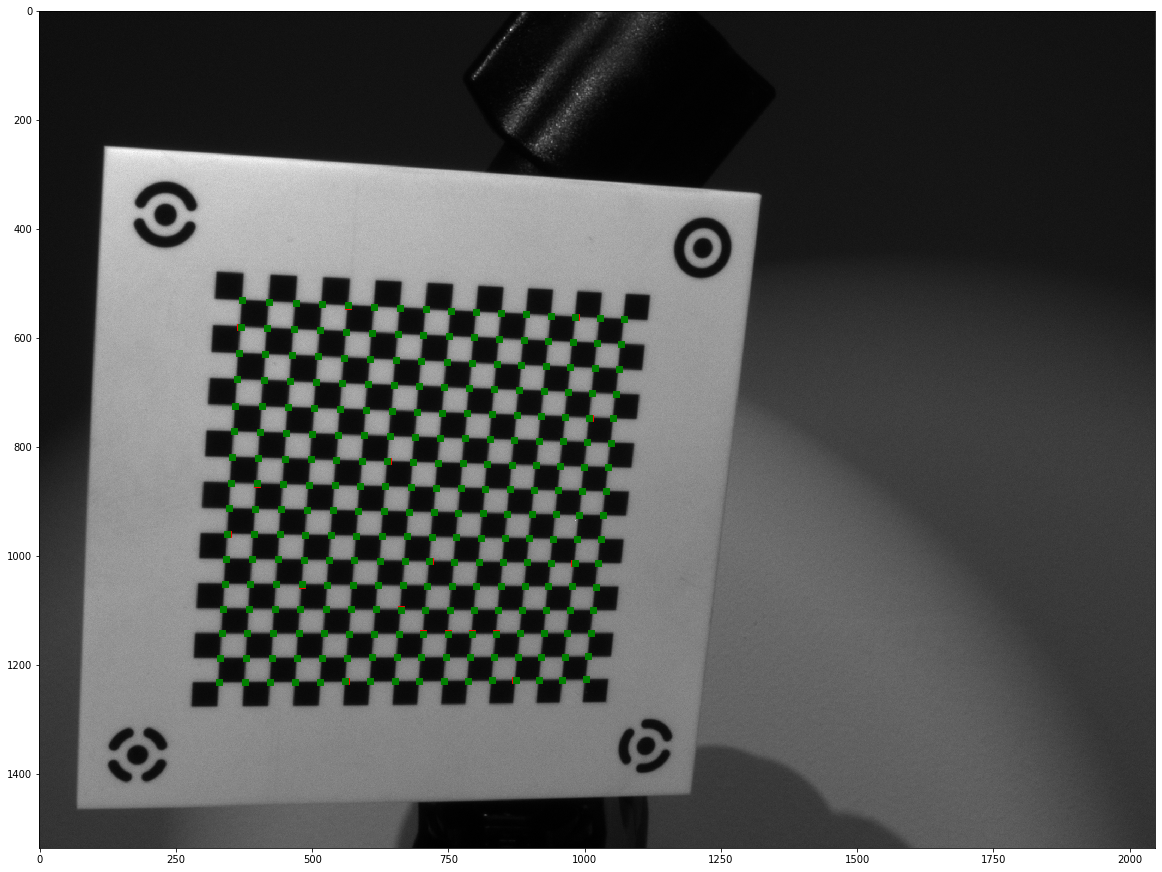

In [34]:
idx=0
plt.figure(figsize=(20,20))
plt.imshow(imgs[idx].array_gs, cmap='gray')
plt.plot(pss_c_p[idx][:,0], pss_c_p[idx][:,1], 'rs')
plt.plot(torch2np(ms[idx](ps_c_w))[:,0], torch2np(ms[idx](ps_c_w))[:,1], 'gs')

# Build

In [35]:
!nbdev_build_lib

Converted cb_geom.ipynb.
Converted control_refine.ipynb.
Converted coordinate_graph.ipynb.
Converted fiducial_detect.ipynb.
Converted image.ipynb.
Converted modules.ipynb.
Converted test.ipynb.
Converted utils.ipynb.
